In [237]:
import sys
import json
params = {}
default = {'training_folder': '../../scenarios/dallas/', 'params': params} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)


{'training_folder': '../../scenarios/dallas/', 'params': {}}


In [238]:
import os
import time
import geopandas as gpd
import pandas as pd
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from sklearn.neighbors import NearestNeighbors
from numba import jit, njit
import numba as nb
from quetzal.model import stepmodel
from shapely.geometry import LineString
from quetzal.io.gtfs_reader.importer import get_epsg
from quetzal.io import excel
on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
num_cores = nb.config.NUMBA_NUM_THREADS
print('num cores:',num_cores)

io_engine= 'pyogrio' if on_lambda else 'pyogrio' #or fiona

num cores: 8


In [239]:
import sys
sys.path.insert(0, r'../../../quetzal')
from quetzal.model import stepmodel
from quetzal.io import excel
import pandas as pd
if manual:
    %matplotlib inline

In [240]:
base_folder = argv['training_folder']
input_folder = os.path.join(base_folder,'inputs/')
pt_folder  = os.path.join(input_folder,'pt/')
road_folder = os.path.join(input_folder,'road/')
od_folder =  os.path.join(input_folder,'od/')
params_folder = input_folder if on_lambda else '../../inputs/'

output_folder = os.path.join(base_folder,'outputs/')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
model_folder = os.path.join(base_folder, 'model/')

In [241]:
sm = stepmodel.read_zippedpickles(model_folder +'los')
sm.segments = ['car_owner', 'pt_captive'] 

zones: 100%|██████████| 28/28 [00:05<00:00,  4.77it/s]           


In [242]:
var = excel.read_var(file=os.path.join(params_folder,'parameters.xlsx'), scenario='base', return_ancestry=False)
kwargs = var['preparation_logit'].to_dict()

utility_scale = var['preparation_logit']['time']
kwargs['transfers'] = -kwargs['transfers']/utility_scale # From min/transfer to pt/transfer
kwargs['price'] = -60/kwargs['price']/utility_scale # From 
kwargs['time'] = -1/utility_scale/60 # From min/pt to pt/sec



{'time': -0.0008333333333333334,
 'price': -0.2,
 'mode': 1,
 'pt_mode': 0.5,
 'pt_path': 0.1,
 'transfers': -0.25}

In [243]:
sm.preparation_logit(
    segments=['car_owner', 'pt_captive'],
    **kwargs
)

In [244]:
sm.utility_values.T

value           time  price  ntransfers  mode_utility
segment                                              
root       -0.000833   -0.2       -0.25           1.0
car_owner  -0.000833   -0.2       -0.25           1.0
pt_captive -0.000833   -0.2       -0.25           1.0

In [245]:
sm.logit_scales.T 

route_type  tram  car  cable_car  walk  rail  root  bus   pt
segment                                                     
root         0.1  0.0        0.1   0.0   0.1   1.0  0.1  0.5
car_owner    0.1  0.0        0.1   0.0   0.1   1.0  0.1  0.5
pt_captive   0.1  0.0        0.1   0.0   0.1   1.0  0.1  0.5

In [246]:
sm.mode_utility.T

route_type  tram  car  cable_car  walk  rail  root  bus
segment                                                
root           0    0          0     0     0     0    0
car_owner      0    0          0     0     0     0    0
pt_captive     0    0          0     0     0     0    0

In [247]:
sm.mode_utility.loc[ 'car', 'pt_captive'] = -100
sm.mode_utility.T

route_type  tram  car  cable_car  walk  rail  root  bus
segment                                                
root           0    0          0     0     0     0    0
car_owner      0    0          0     0     0     0    0
pt_captive     0 -100          0     0     0     0    0

In [248]:
sm.mode_nests.T 

route_type tram   car cable_car  walk rail root bus    pt
segment                                                  
root         pt  root        pt  root   pt  NaN  pt  root
car_owner    pt  root        pt  root   pt  NaN  pt  root
pt_captive   pt  root        pt  root   pt  NaN  pt  root

In [249]:
sm.pt_los['ntransfers'] = sm.pt_los['alighting_links'].apply(lambda x: max(len(x)-1, 0))
sm.pt_los['price'] = 0  ######
sm.car_los['ntransfers'] = 0
sm.car_los['price'] = 0

In [250]:
sm.analysis_pt_time(
        boarding_time=None,
        alighting_time=None,
        walk_on_road=True,
    )
 

sm.analysis_car_route_type() 

sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)
sm.los['path'] = sm.los['path'].apply(lambda p: tuple(p)) 


sm.analysis_mode_utility()

100%|██████████| 2/2 [00:00<00:00, 38.93it/s]


In [251]:
sm.initialize_logit()
sm.step_logit()

100%|██████████| 10/10 [00:00<00:00, 10.16it/s]


In [252]:
sm.volumes.fillna(0, inplace=True)
sm.compute_los_volume(keep_segments=False)

In [254]:
sm.pt_los = sm.los.copy()
sm.pt_los = sm.pt_los.loc[sm.pt_los['route_type'] != 'car']

In [255]:
sm.step_pt_assignment(
    road=True,
    boardings=True,
    alightings=True,
    transfers=True
 
)

pt_captive: 100%|██████████| 2/2 [00:03<00:00,  1.97s/it]


In [256]:
sm.links.rename(columns={'load': 'volume'}, inplace=True)
sm.analysis_pt_length(
     walk_on_road=True
)
sm.analysis_car_length()
sm.analysis_pt_time(
     walk_on_road=True
)

In [257]:
sm.summary_link_max(inplace=True)
sm.summary_link_sum(inplace=True)
sm.summary_od(inplace=True)

In [258]:
sm.los = pd.concat([sm.pt_los, sm.car_los]).reset_index(drop=True)

In [259]:
sm.summary_path_average(inplace=True)
sm.summary_aggregated_path_average(inplace=True, pt_route_types=['subway', 'bus', 'tram', 'rail'])
sm.summary_path_sum(inplace=True)

s = sm.stack_link_sum.unstack([-1, -2]).groupby(level=0).sum().stack([0, 1])
s.name = 'sum'
sm.stack_aggregated_link_sum = s 
s = sm.stack_link_max.unstack().groupby(level=0).max().stack()
s.name = 'max'
sm.stack_aggregated_link_max = s

In [267]:
sm.to_zippedpickles(model_folder + 'logit_assignment')

  0%|          | 0/47 [00:00<?, ?it/s]

stack_aggregated_link_max: 100%|██████████| 47/47 [00:24<00:00,  1.96it/s]


In [268]:
end_of_notebook

NameError: name 'end_of_notebook' is not defined

In [269]:
if manual:   
    od_test = gpd.read_file(od_folder + 'od.geojson')
    from shapely.geometry import Point
    from syspy.spatial.spatial import nearest, agglomerative_clustering, voronoi_diagram_dataframes, add_geometry_coordinates
    od_test['geometry_o'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][0]))
    od_test['geometry_d'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][1]))
    # find nearest node with KNN. nodes are now the origin and destination.
    od_test['geometry'] = od_test['geometry_o']
    neigh = nearest(od_test, sm.zones.to_crs(4326), n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
    zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
    od_test['origin'] = od_test.index.map(zone_node_dict.get)

    od_test['geometry'] = od_test['geometry_d']
    neigh = nearest(od_test, sm.zones.to_crs(4326), n_neighbors=1).rename(columns={'ix_one': 'zone_index', 'ix_many': 'node_index'})
    zone_node_dict = neigh.set_index('zone_index')['node_index'].to_dict()
    od_test['destination'] = od_test.index.map(zone_node_dict.get)

    od_test = od_test.drop(columns=['geometry_o','geometry_d','geometry'])
    od_test = od_test.drop(columns=['index'])

    od_list= od_test[['origin','destination','name']].values.tolist()

    



name    origin destination
0                     forthWorth_to_dallas   zone_57    zone_364
1                  mesquite_to_grandPairie  zone_291    zone_322
2                     denton_to_carrollton  zone_244     zone_48
3                          plano_to_dallas  zone_445    zone_364
4            mesquite_to_universityOfTexas  zone_291     zone_88
5                         irving_to_dallas  zone_256    zone_364
6            dallas_to_dallasMedicalCenter  zone_364    zone_129
7       garland_to_dallasForthWorthAirport  zone_353    zone_416
8  oldEastDallas_to_methodistMedicalCenter  zone_364    zone_289
9                       oakCliff_to_dallas  zone_138    zone_364

In [271]:
if manual:

    import numpy as np
    paths = sm.pt_los
    link_routes = sm.links['route_short_name'].to_dict()
    def link_path_to_routes(link_path):
        routes = [link_routes[l] for l in link_path]
        used = set()
        rsn = []
        for route in routes:
            if route not in used:
                rsn.append(route)
            used.add(route)
        return rsn

    paths['route_path'] = paths['link_path'].apply(link_path_to_routes)
    paths['ntransfers'] = paths['transfers'].apply(len)

    def title(paths):
        paths['min'] = np.round(paths['time'] / 60).astype(int)
        mins = (paths[['in_vehicle_time', 'access_time', 'footpath_time', 'waiting_time', 'time']] / 60).astype(int).astype(str)
        title = 'P = ' + (np.round(paths[('pt_captive', 'probability')], 2).fillna(0) * 100).astype(int).astype(str) + '%'
        title += ' | '+  paths['ntransfers'].astype(str) + ' transfers '
        title += ' | '+  paths['min'].astype(str) + ' mins | '
        title += paths['route_path'].apply(lambda l: '—>'.join(l) )
        title += '\n'+ 'in vehicle '+ mins['in_vehicle_time']+ "' | " + ' waiting '+ mins['waiting_time']+ "' | "  
        title += 'access ' + mins['access_time']+ "' | "   + ' footpaths '  + mins['footpath_time']+ "'"   
        return title


    paths['title'] = title(paths)

In [273]:
plot_sm = sm.copy()
los = plot_sm.pt_los.copy()
los= los.loc[los[('pt_captive', 'probability')] > 0.01]
plot_sm.pt_los = los.sort_values(('pt_captive', 'probability'), ascending=False)
sm.pt_los = sm.pt_los.sort_values(('pt_captive', 'probability'), ascending=False)

100%|██████████| 2/2 [00:01<00:00,  1.86it/s]


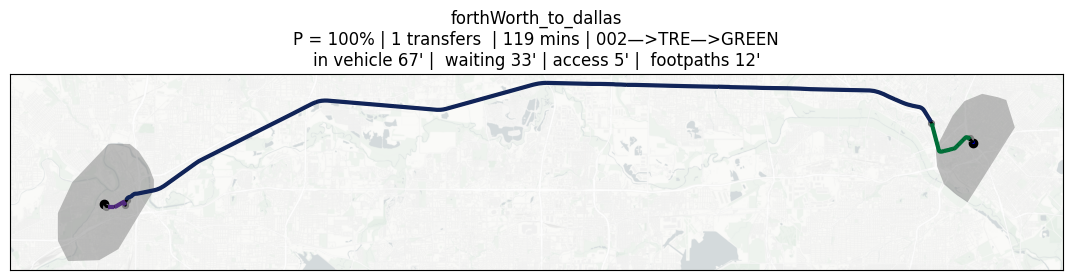

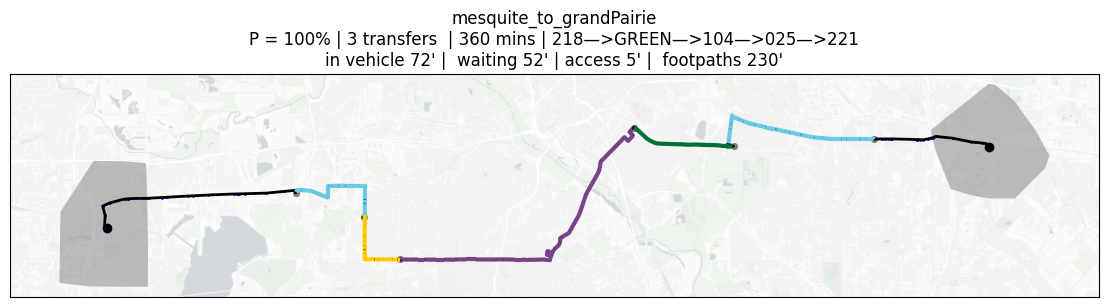

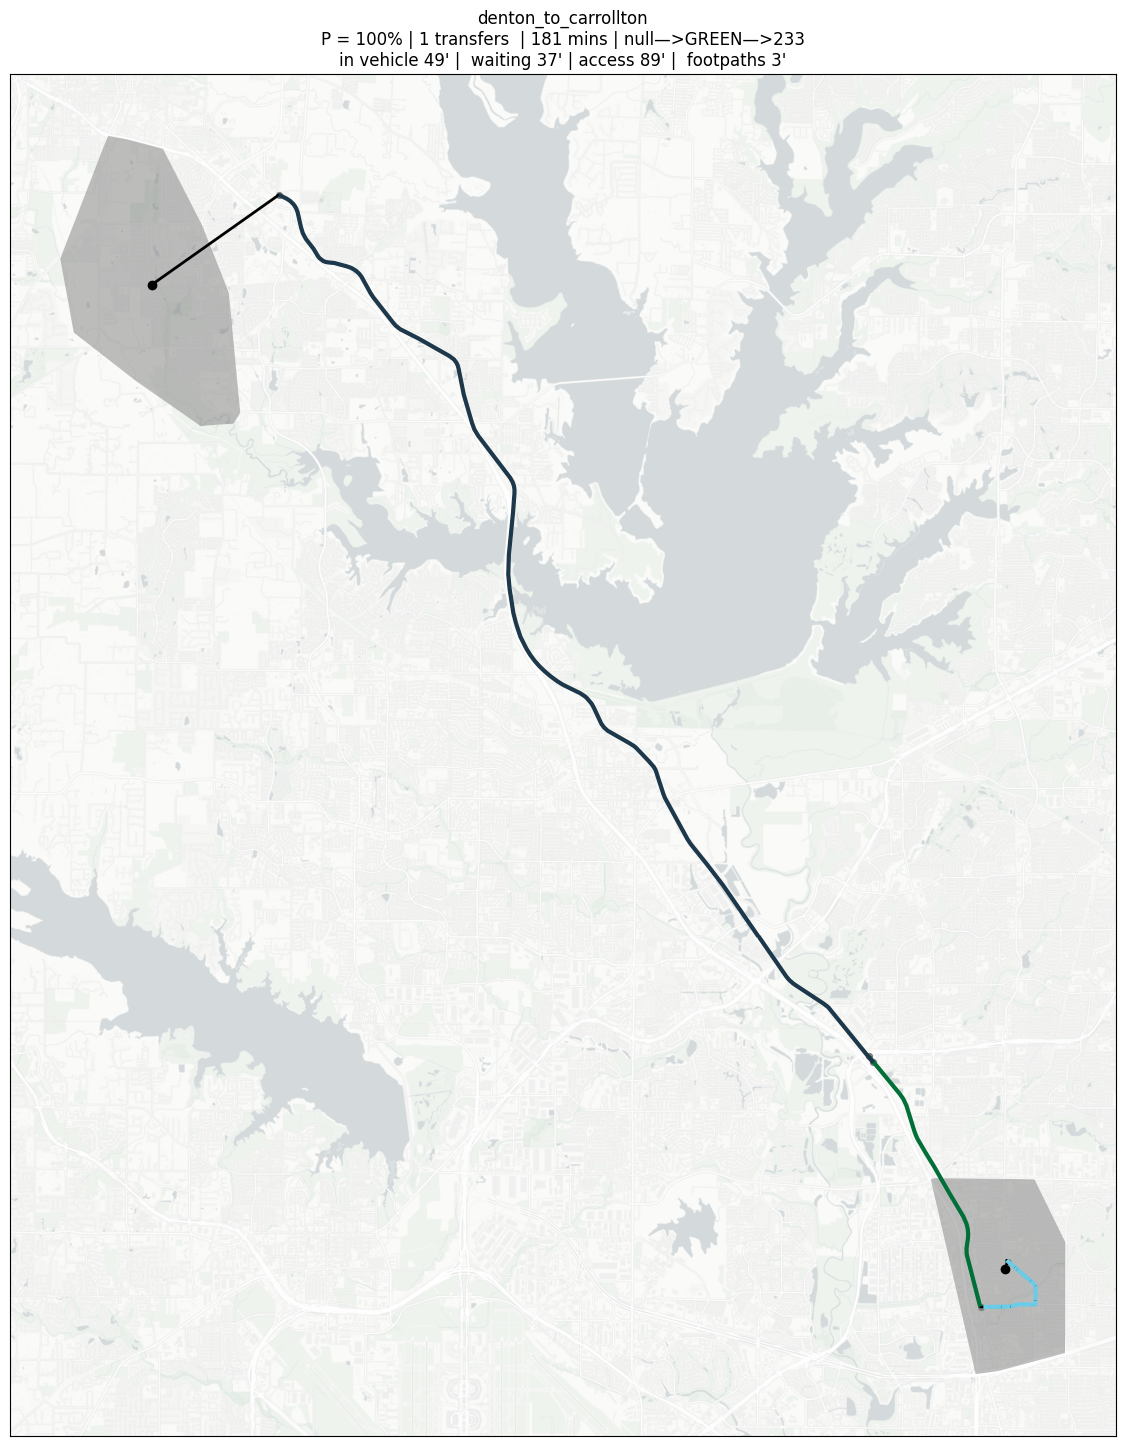

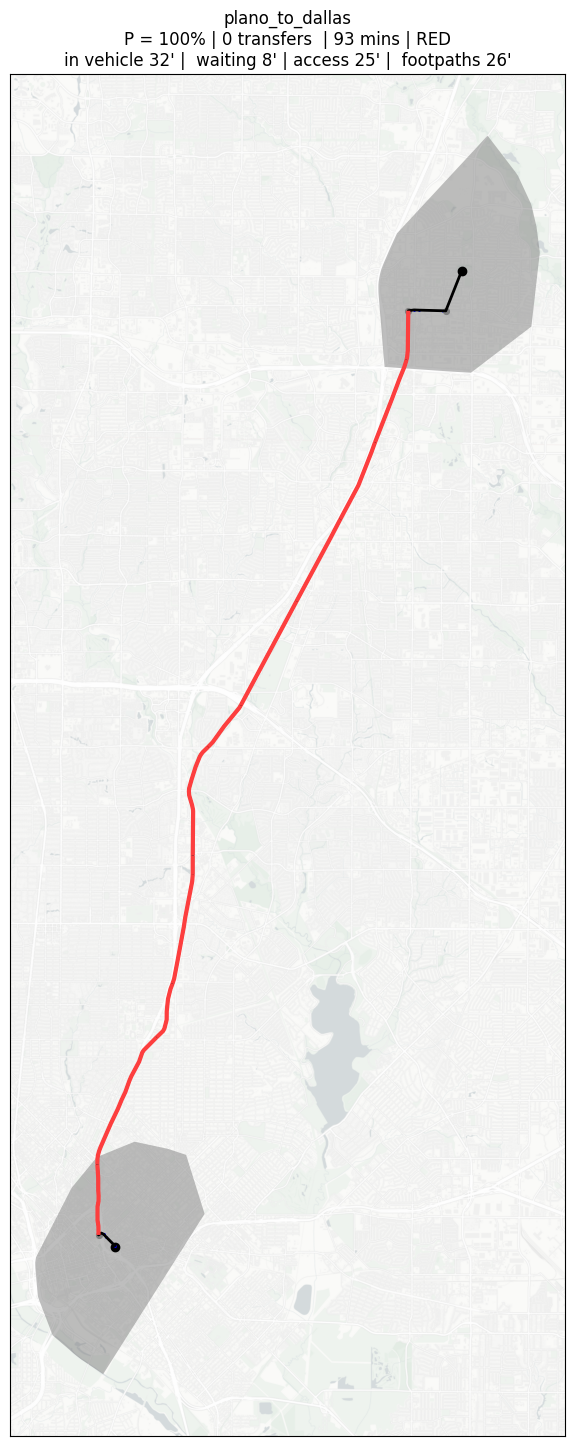

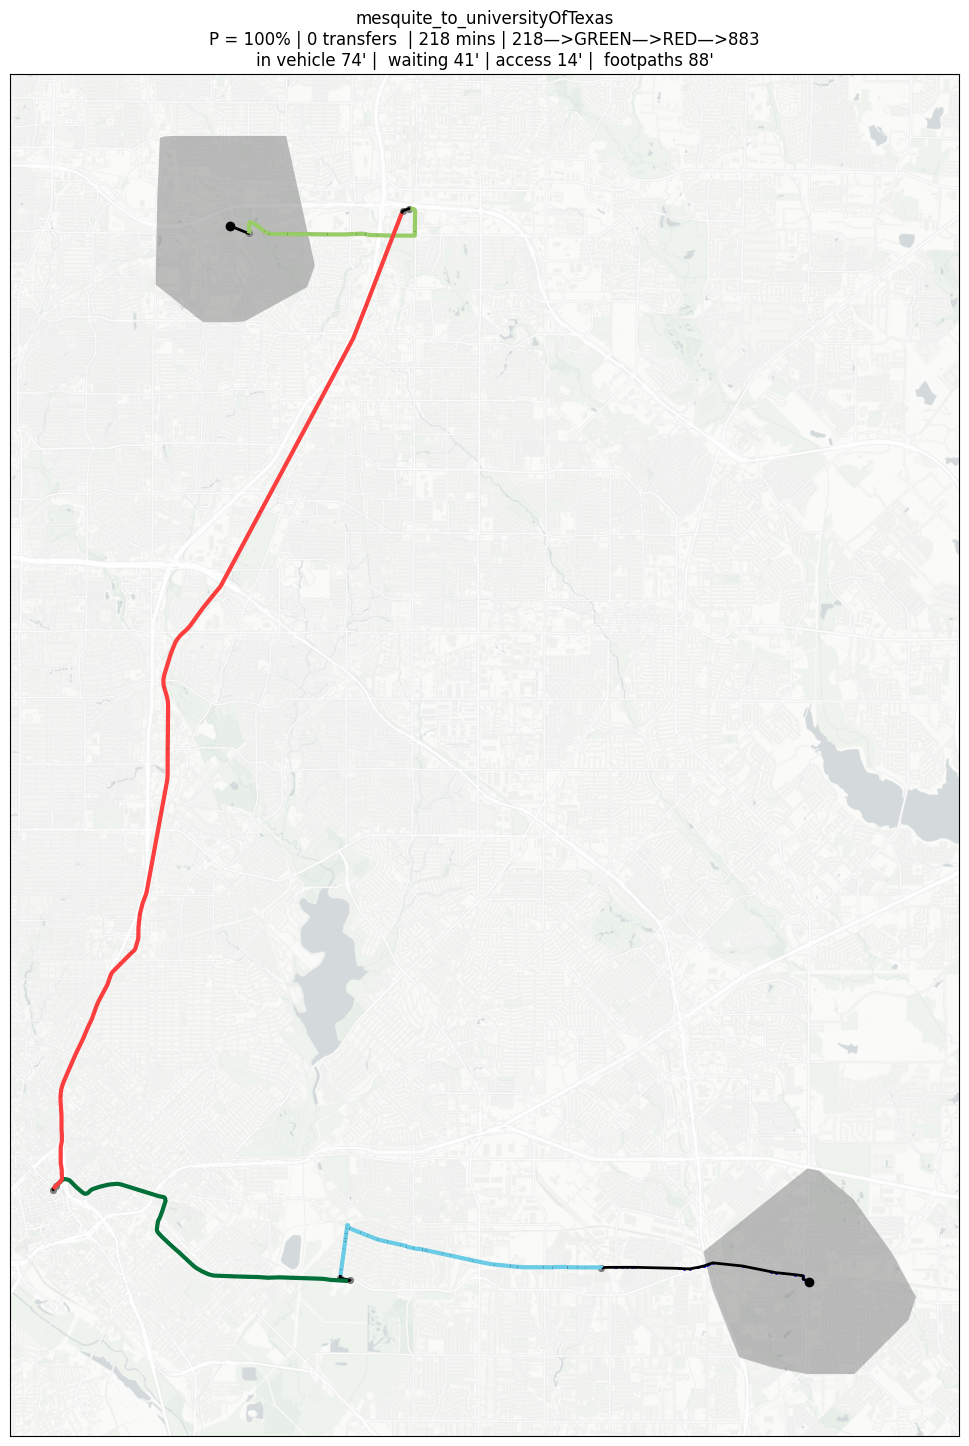

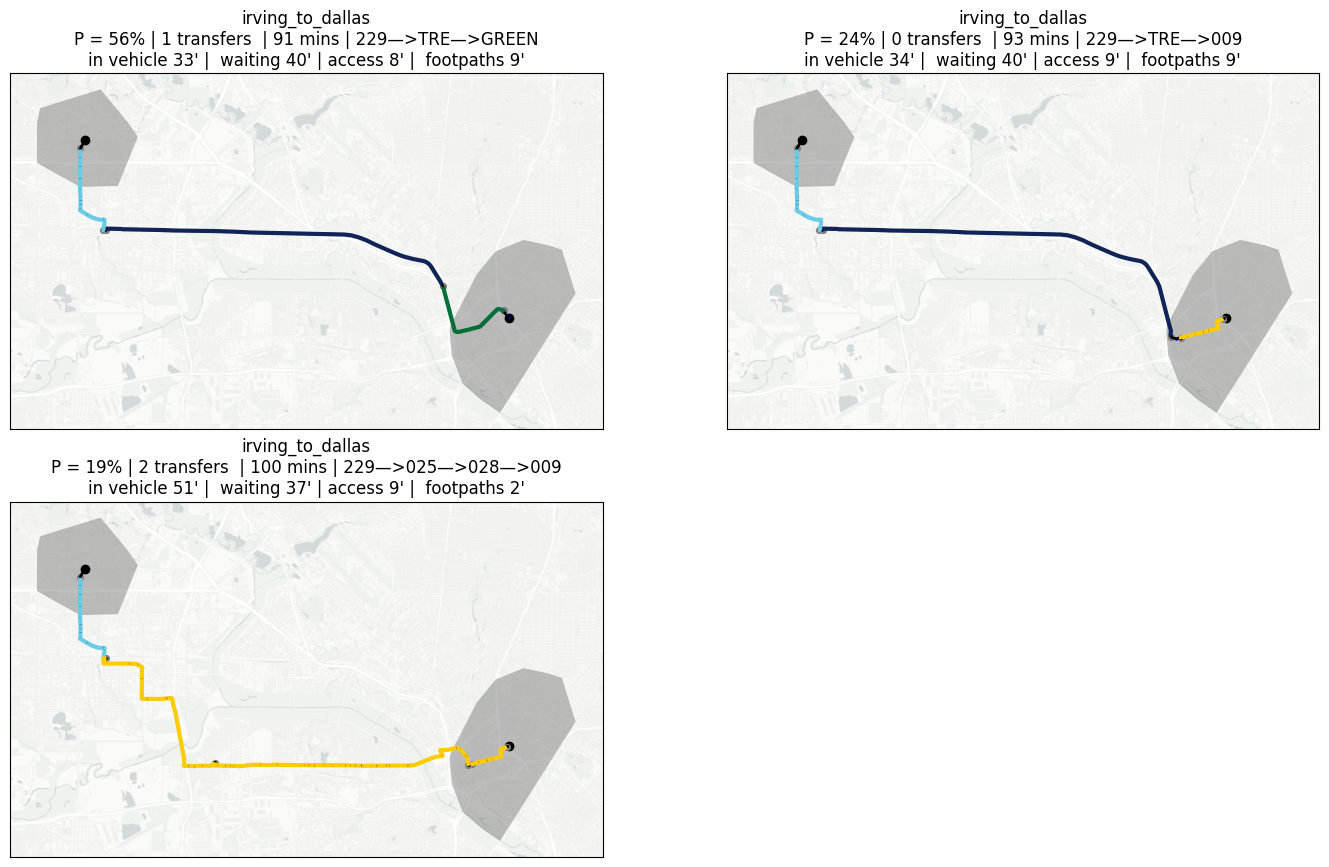

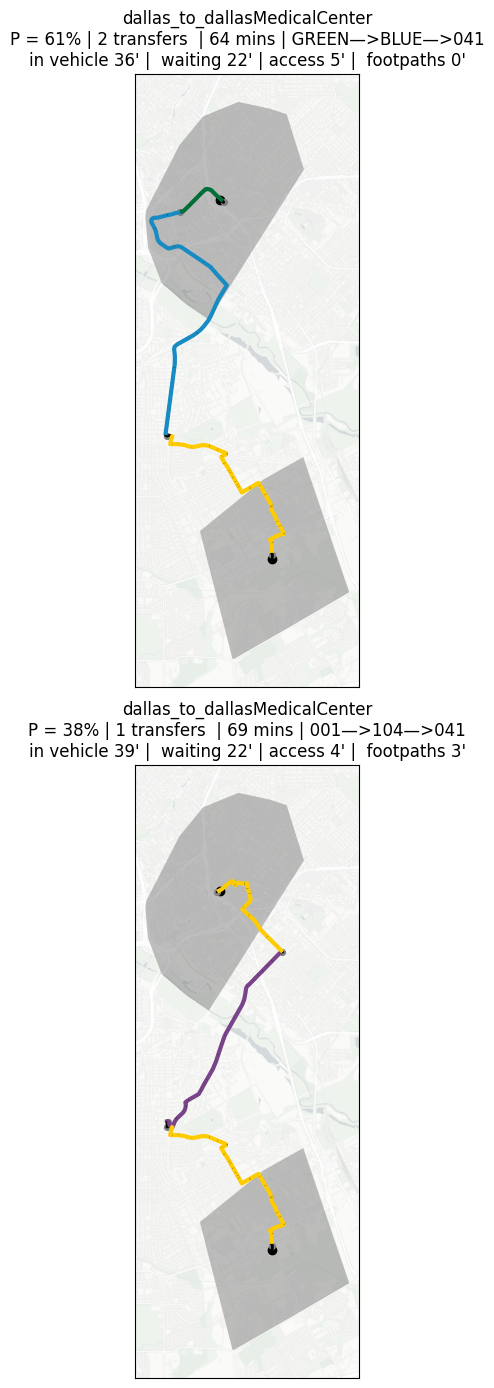

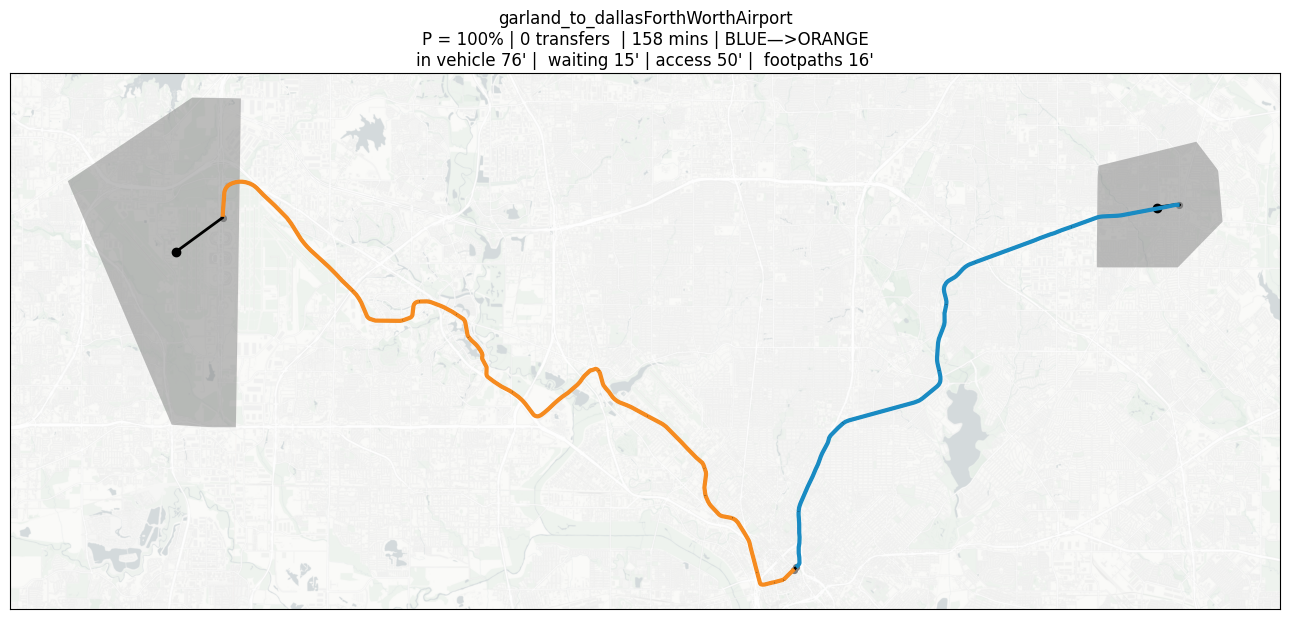

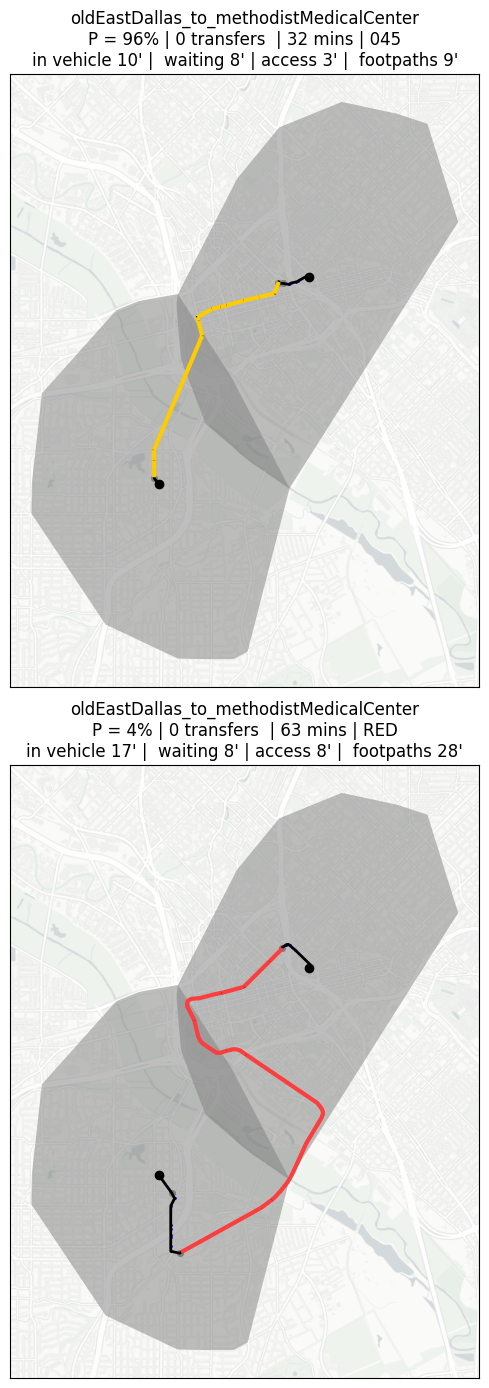

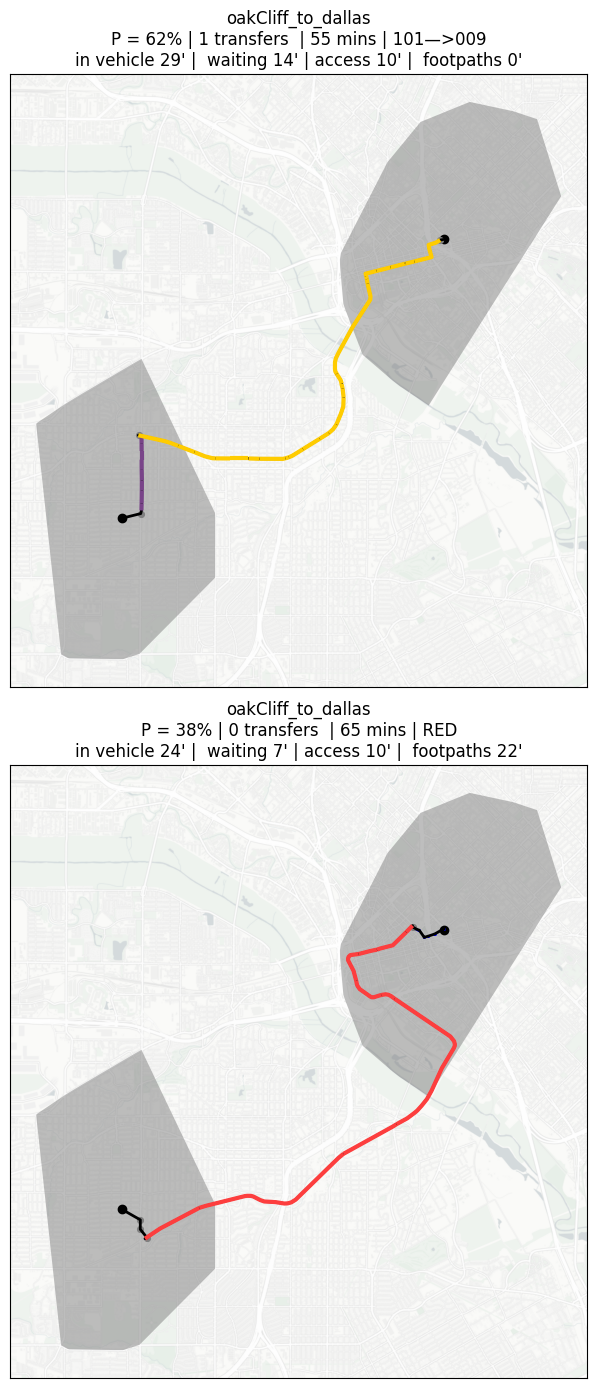

In [275]:
plot_sm = plot_sm.change_epsg(epsg =3857, coordinates_unit = 'meter')
plot_sm.links['color'] = '#' +plot_sm.links['route_color']
styles = plot_sm.get_geometries()

if manual:
 
    for o,d, name in od_list:
        origin, destination= o, d
        n =  len(plot_sm.pt_los.set_index(['origin', 'destination']).loc[[(origin, destination)]])
        rows = 1
        if n > 1:
            rows = 2
        if n > 6:
            rows = 3
        if n > 12:
            rows = 4
 
        columns = n // rows + bool(n%rows)
 
        url = 'http://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png'
        fig, axes = plot_sm.plot_separated_paths(
            origin, destination, rows=rows, figsize=[15, 15],
            title='title', constrained_layout=True, styles = styles,
            basemap_url=url, zoom=14
        )
        for ax in axes:
            ax.set_title(name + '\n' + ax.get_title())
        ax = fig.get_axes()[0]
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.set_size_inches(bbox.width*columns, rows*(bbox.height))
        fig.constrained_layout = True
        png = output_folder+ 'OD_googlemaps_' +name + '.png'
        fig.savefig(png, bbox_inches='tight')